<a href="https://colab.research.google.com/github/pranay8297/DiffEdit/blob/master/DiffEditExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq diffusers transformers fastcore ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.7 MB/s eta 0:00:00


In [2]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline

from fastcore.all import concat

from huggingface_hub import notebook_login
from PIL import Image

from ipdb import set_trace as st
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline
from fastdownload import FastDownload

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

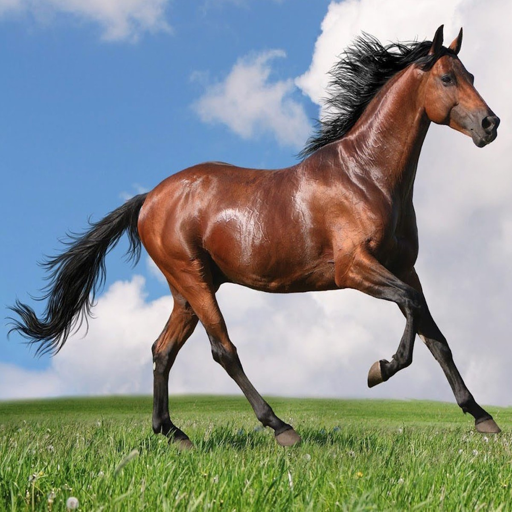

In [3]:
p = FastDownload().download('https://iadsb.tmgrup.com.tr/7ddb86/0/0/0/0/1926/1086?u=https://idsb.tmgrup.com.tr/2018/05/22/horses-the-wings-of-mankind-1527015927739.jpg')
img = Image.open('/root/.fastdownload/archive/horses-the-wings-of-mankind-1527015927739.jpg').crop((0, 0, 1200, 1086)).resize((512, 512))
img

In [4]:
from torchvision import transforms
im_tensor = transforms.ToTensor()(img)

In [5]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import LMSDiscreteScheduler

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

beta_start, beta_end = 0.00085, 0.012
scheduler = LMSDiscreteScheduler(beta_start = beta_start, beta_end = beta_end, beta_schedule = "scaled_linear", num_train_timesteps = 1000)



Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [6]:
device = torch.device('cuda')
im_tensor = im_tensor.to(device).to(torch.float16)
with torch.no_grad():
  latents = vae.encode(im_tensor[None, :]).latent_dist.sample()

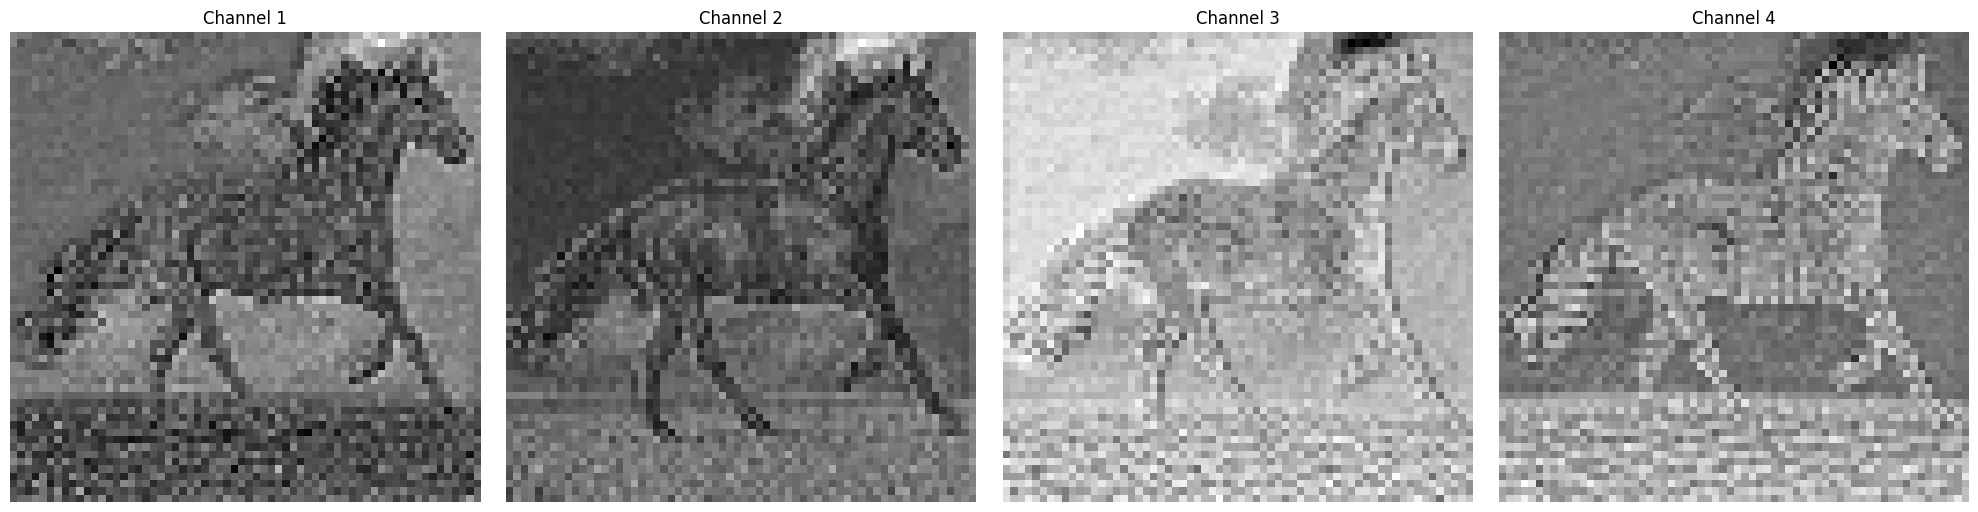

In [7]:
# visualizing the latents.
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(latents[0][i].to('cpu').detach().numpy(), cmap='gray')
    axs[i].axis('off')  # Hide axes for better visualization
    axs[i].set_title(f"Channel {i + 1}")

plt.tight_layout()
plt.show()

# Exp - 1.1.1: Adding Noise to the latent space - Wrong Way

In [ ]:
latents

tensor([[[[ 9.0625,  8.0078,  8.0312,  ...,  9.8828,  9.7344,  9.7969],
          [ 9.4219,  3.6875,  6.2812,  ..., 11.0547, 10.8047, 10.4375],
          [ 6.5078,  6.2656,  5.5938,  ..., 11.3672, 10.3984, 10.9922],
          ...,
          [ 1.3340,  6.0312,  0.1941,  ...,  1.7930,  3.6875,  1.3203],
          [ 3.9102,  2.2930, -1.2012,  ...,  2.5566, -1.6084,  6.1016],
          [ 4.3828,  6.6016,  6.6562,  ...,  6.6719, 12.9219,  6.5078]],

         [[ 5.1797,  5.5039,  2.6660,  ...,  7.6406,  7.3750,  9.1172],
          [ 1.7139,  0.5405,  1.9023,  ...,  6.7422,  6.6172, 11.9453],
          [ 0.3289,  2.4004,  0.9336,  ...,  8.2031,  5.8750, 10.7500],
          ...,
          [ 7.5625,  4.0742,  7.1523,  ...,  8.3750,  6.8125,  8.5156],
          [-0.2356,  9.1094,  6.6016,  ...,  7.3945,  8.2500, 10.2031],
          [ 0.8701, 10.2734,  5.8281,  ...,  7.2891,  9.5703,  6.9414]],

         [[-1.6807, -0.8354,  1.5830,  ..., -2.8125, -2.2402, -3.3457],
          [ 3.8809,  3.2891,  

In [ ]:
def add_gaussian_noise(latents, std_dev = 0.5):

  noise = torch.normal(mean = 0, std = std_dev, size = latents.size(), device = latents.device, dtype = latents.dtype)
  return latents * 0.18215 + noise

In [ ]:
latents_with_noise = add_gaussian_noise(latents)


In [ ]:
def decode(latents):

  with torch.no_grad():
    images = vae.decode(1 / 0.18215 * latents).sample
  return images

def show_image(image):
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(1, 2, 0).numpy()
  image = (image * 255).round().astype("uint8")
  return Image.fromarray(image)



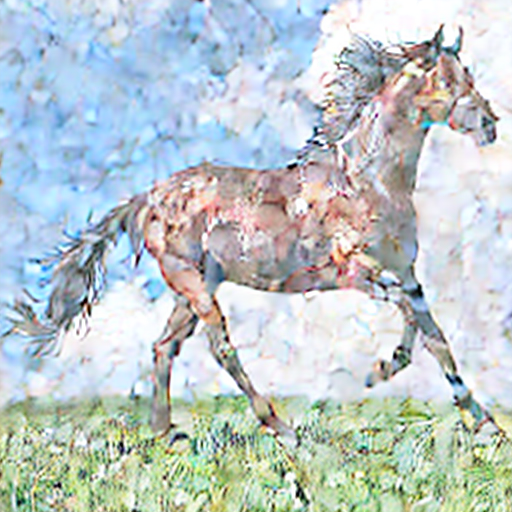

In [ ]:
show_image(decode(latents_with_noise)[0])

# Exp 1.1.2 - Adding noise to pixel space - Wrong way way


In [ ]:
def add_gaussian_noise_to_image(image, std_dev=0.5):
    """
    Add Gaussian noise with a given standard deviation to an image.

    Args:
    - image (torch.Tensor): The image tensor of shape [3, H, W].
    - std_dev (float): Standard deviation of the Gaussian noise.

    Returns:
    - torch.Tensor: Noisy image.
    """
    noise = torch.normal(mean=0, std=std_dev, size=image.size(), device=image.device, dtype = image.dtype)
    noisy_image = image + noise

    # Clip values to ensure they are within valid range (assuming [0, 1] range for image)
    noisy_image = torch.clamp(noisy_image, 0, 1)

    return noisy_image

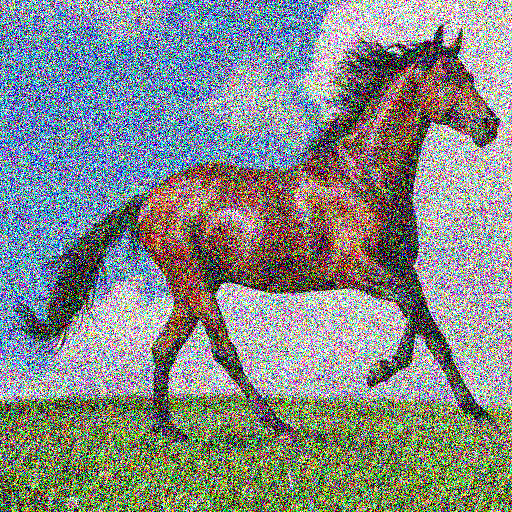

In [ ]:
noisy_img = add_gaussian_noise_to_image(im_tensor)
from torchvision.transforms import ToPILImage
ToPILImage()(noisy_img)

In [ ]:
def convert_to_latents(image_tensor):

  # Make sure image_tensor is a batch object

  with torch.no_grad():
    latents = vae.encode(image_tensor).latent_dist.sample()
  return latents

In [ ]:
noisy_latents = convert_to_latents(noisy_img[None, :])
noisy_latents.shape

torch.Size([1, 4, 64, 64])

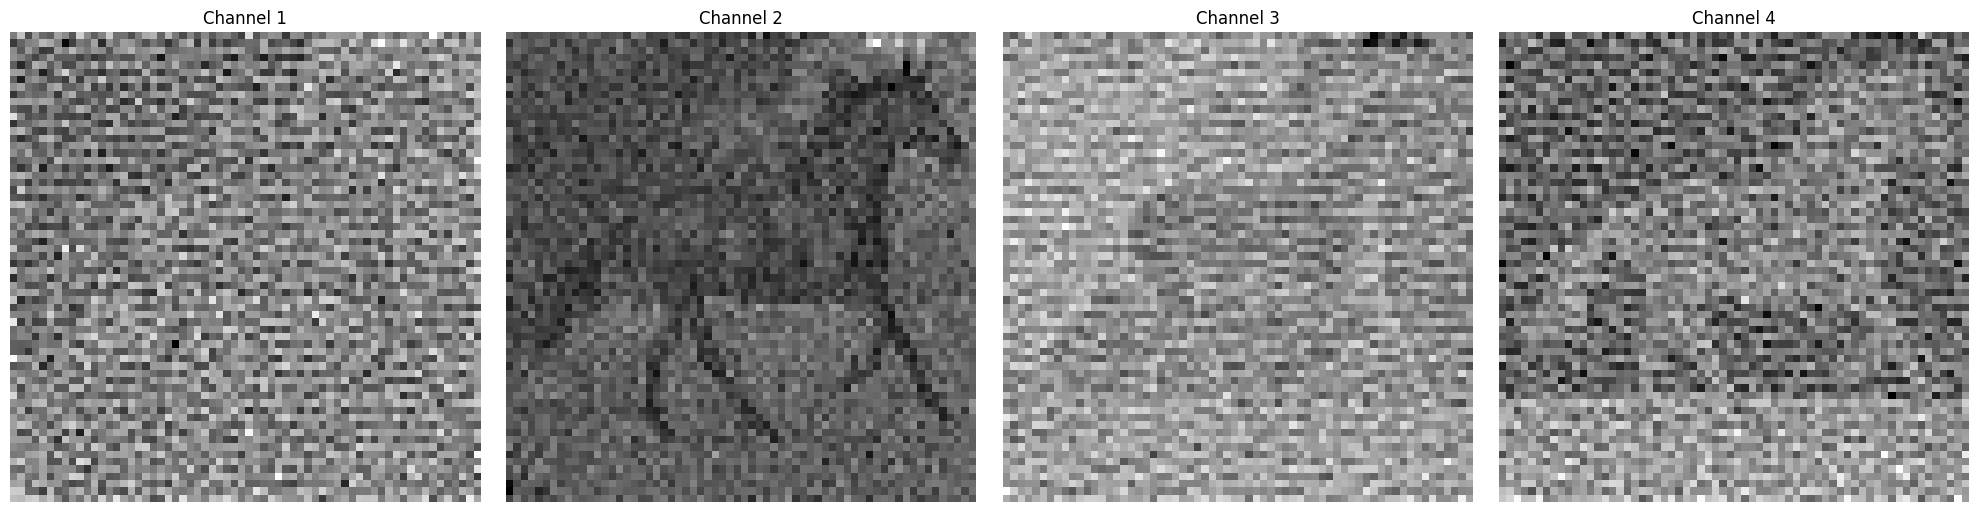

In [ ]:
# Visualizing the noisy latents
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(noisy_latents[0][i].to('cpu').detach().numpy(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"Channel {i + 1}")

plt.tight_layout()
plt.show()

# Exp 1.2.1: Getting Noise Estimates using two texts and computing mask

In [ ]:
# We require 3 things here

# 1. Text encoding flow
# 2. Scheduler for timesteps and noise scaling
# 3. Denoising part

In [ ]:
# 1. Text encoding flow
def encode_text(inputs = ['']):

    uncond_inputs = [''] * len(inputs)
    all_inputs = uncond_inputs + inputs
    all_inputs_tokenized = tokenizer(all_inputs, padding = 'max_length', max_length = tokenizer.model_max_length, truncation=True, return_tensors="pt").input_ids.to('cuda')
    embeddings = text_encoder(all_inputs_tokenized)[0].half()
    return embeddings

ref_embs = encode_text(['Horse'])
query_embs = encode_text(['Zebra'])

In [ ]:
# 2. Scheduelr
num_inference_steps = 30
scheduler.set_timesteps(num_inference_steps)

In [ ]:
scheduler.sigmas[15:]

tensor([1.5257, 1.3619, 1.2166, 1.0865, 0.9691, 0.8622, 0.7640, 0.6730, 0.5877,
        0.5067, 0.4286, 0.3515, 0.2722, 0.1835, 0.0292, 0.0000])

In [ ]:
# scaling the latents
# latents_for_computation = torch.randn((1, 4, 64, 64), dtype = noisy_latents.dtype, device = device)
latents_for_computation = noisy_latents
# latents_for_computation = latents_with_noise

In [ ]:
# Denoising Part
guidance_scale = 7.5
scheduler.set_timesteps(num_inference_steps)
latents_for_computation = latents_for_computation * scheduler.init_noise_sigma

for i, t in enumerate(tqdm(scheduler.timesteps)):

  input = torch.cat([latents_for_computation]*2)
  input = scheduler.scale_model_input(input, t)

  # Predict the Noise
  with torch.no_grad():
    noise_pred = unet(input, t, encoder_hidden_states = ref_embs).sample

  n_u, n_p = noise_pred.chunk(2)
  pred = n_u + guidance_scale * (n_p - n_u)

  latents_for_computation = scheduler.step(pred, t, latents_for_computation).prev_sample

  0%|          | 0/30 [00:00<?, ?it/s]

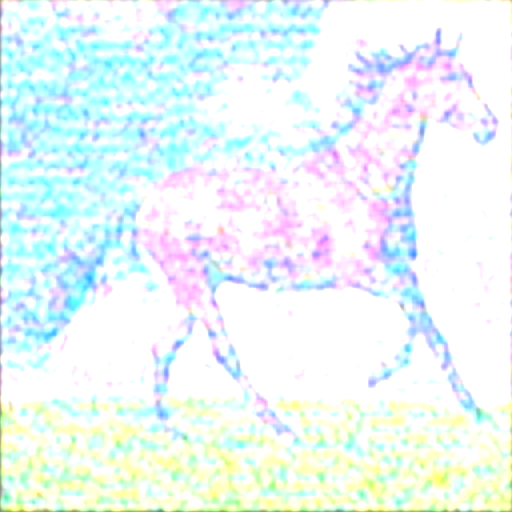

In [ ]:
with torch.no_grad():
  image = vae.decode(1 / 0.18215 * latents_for_computation).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

  0%|          | 0/30 [00:00<?, ?it/s]

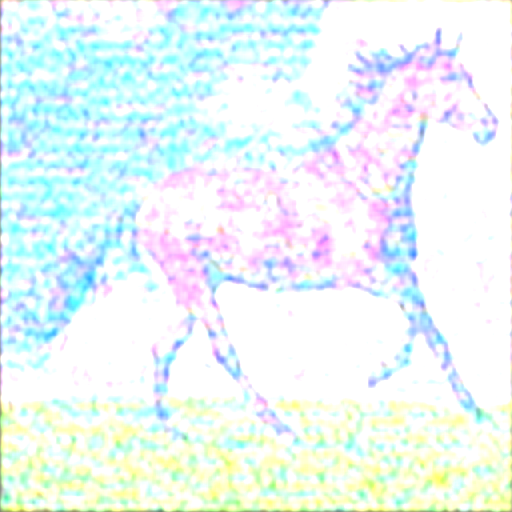

In [ ]:
# Denoising Part - with query embs
latents_for_computation = noisy_latents

guidance_scale = 7.5
scheduler.set_timesteps(num_inference_steps)
latents_for_computation = latents_for_computation * scheduler.init_noise_sigma

for i, t in enumerate(tqdm(scheduler.timesteps)):

  input = torch.cat([latents_for_computation]*2)
  input = scheduler.scale_model_input(input, t)

  # Predict the Noise
  with torch.no_grad():
    noise_pred = unet(input, t, encoder_hidden_states = query_embs).sample

  n_u, n_p = noise_pred.chunk(2)
  pred = n_u + guidance_scale * (n_p - n_u)

  latents_for_computation = scheduler.step(pred, t, latents_for_computation).prev_sample

with torch.no_grad():
  image = vae.decode(1 / 0.18215 * latents_for_computation).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

# EXP 1.2.2

In [ ]:
latents.shape, latents.dtype, latents.device

(torch.Size([1, 4, 64, 64]), torch.float16, device(type='cuda', index=0))

In [ ]:
ref_embs = text_encoder(tokenizer(['Horse'], padding = 'max_length', max_length = tokenizer.model_max_length, truncation=True, return_tensors="pt").input_ids.to('cuda'))[0].half()
query_embs = text_encoder(tokenizer(['Zebra'], padding = 'max_length', max_length = tokenizer.model_max_length, truncation=True, return_tensors="pt").input_ids.to('cuda'))[0].half()


In [ ]:
scheduler.set_timesteps(10)

In [ ]:
noisy_latents = torch.normal(mean=0, std = 0.5, size=latents.size(), device=latents.device, dtype = latents.dtype) + latents

In [ ]:
with torch.no_grad():
  noise_ref = unet(noisy_latents, scheduler.timesteps[0], encoder_hidden_states = ref_embs).sample
  noise_query = unet(noisy_latents, scheduler.timesteps[0], encoder_hidden_states = query_embs).sample


In [ ]:
noise_mask = noise_ref - noise_query

In [ ]:
noise_mask.shape

torch.Size([1, 4, 64, 64])

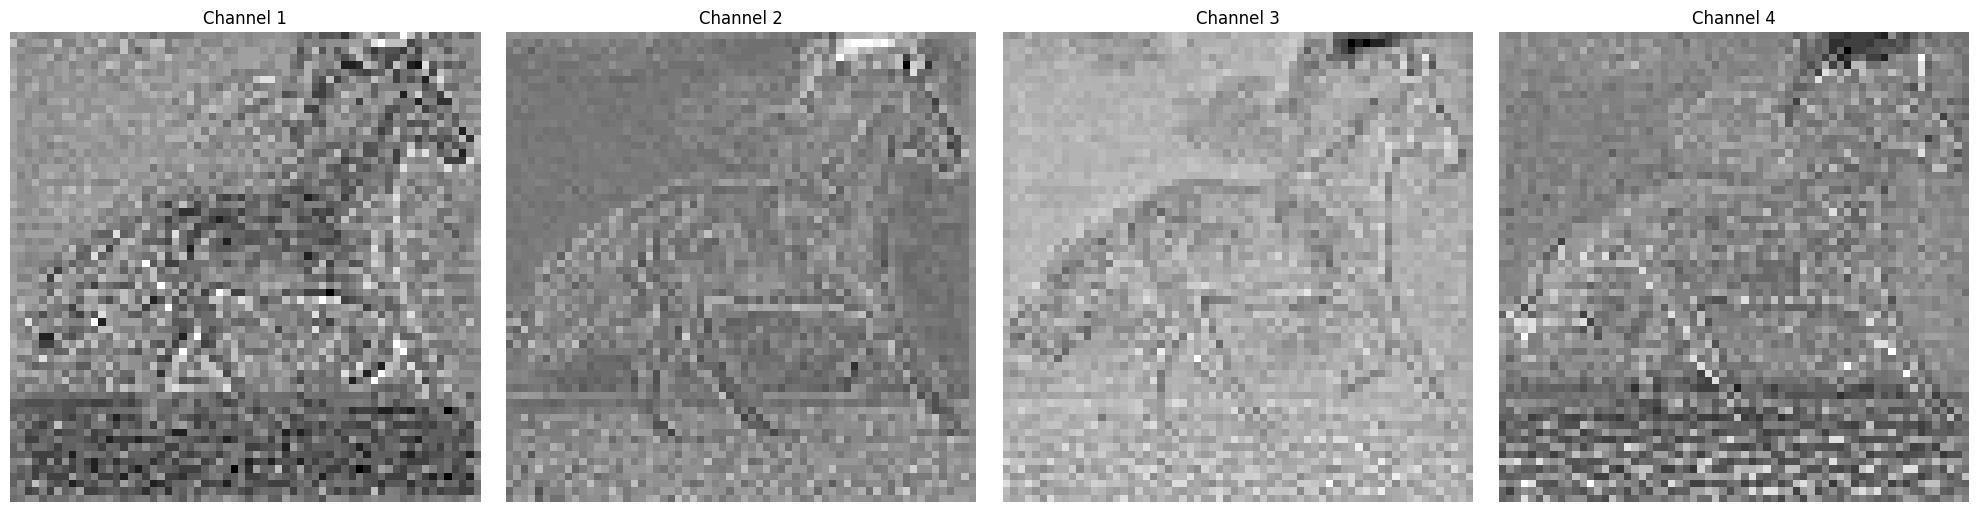

In [ ]:
# visualizing the latents.
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(noise_mask[0][i].to('cpu').detach().numpy(), cmap='gray')
    axs[i].axis('off')  # Hide axes for better visualization
    axs[i].set_title(f"Channel {i + 1}")

plt.tight_layout()
plt.show()

In [ ]:
# Averaging for 10 different sample

noise_std_dev = torch.linspace(0.4, 0.6, 10)

In [ ]:
noise_std_dev

tensor([0.4000, 0.4222, 0.4444, 0.4667, 0.4889, 0.5111, 0.5333, 0.5556, 0.5778,
        0.6000])

In [ ]:
difference = torch.zeros(latents.size(), dtype = latents.dtype, device = latents.device)
for noise_std in tqdm(noise_std_dev):

  noisy_latents = latents + torch.normal(mean=0, std = noise_std, size=latents.size(), device=latents.device, dtype = latents.dtype)

  with torch.no_grad():
    noise_r = unet(noisy_latents, scheduler.timesteps[0], ref_embs).sample
    noise_q = unet(noisy_latents, scheduler.timesteps[0], query_embs).sample

  difference += noise_q - noise_r

difference = difference/10

  0%|          | 0/10 [00:00<?, ?it/s]

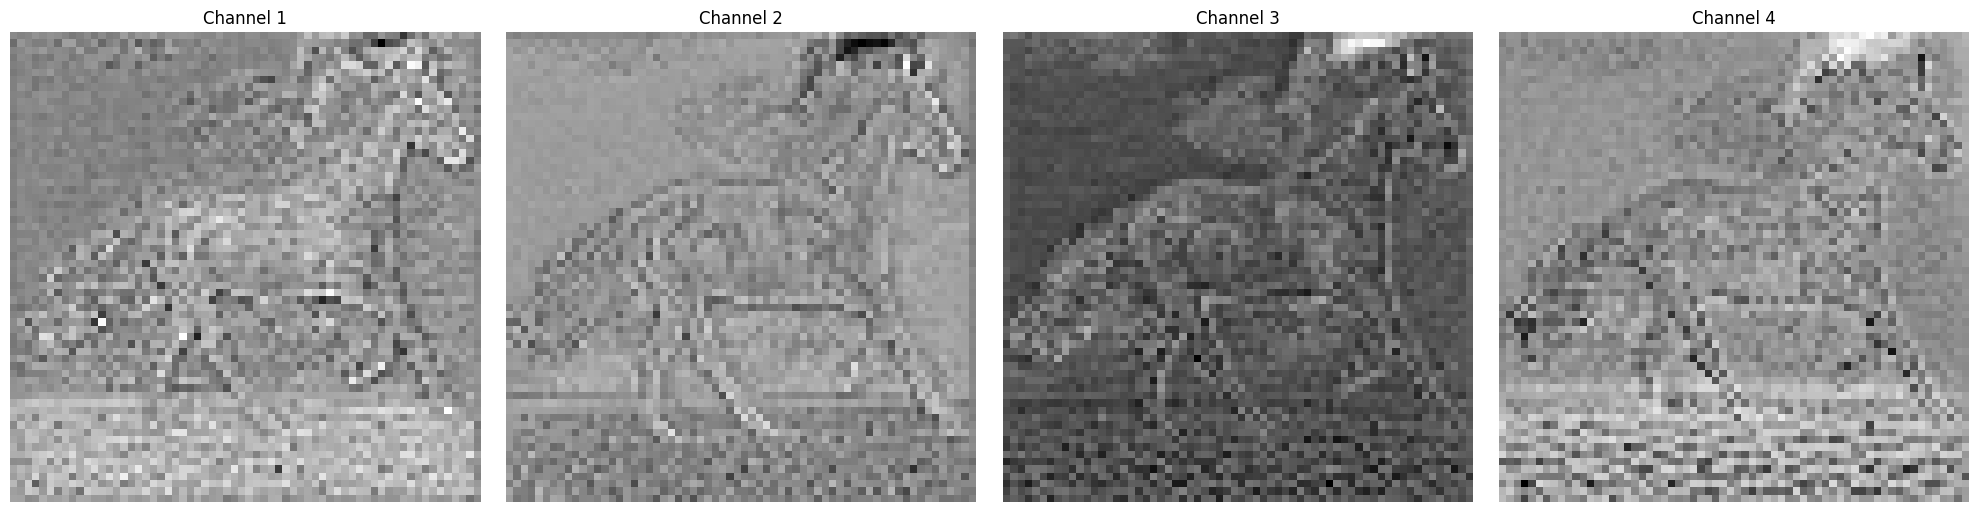

In [ ]:
# visualizing the latents.
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(difference[0][i].to('cpu').detach().numpy(), cmap='gray')
    axs[i].axis('off')  # Hide axes for better visualization
    axs[i].set_title(f"Channel {i + 1}")

plt.tight_layout()
plt.show()

In [ ]:
clipped_difference = torch.clamp(difference, min = -0.5, max = 0.5)

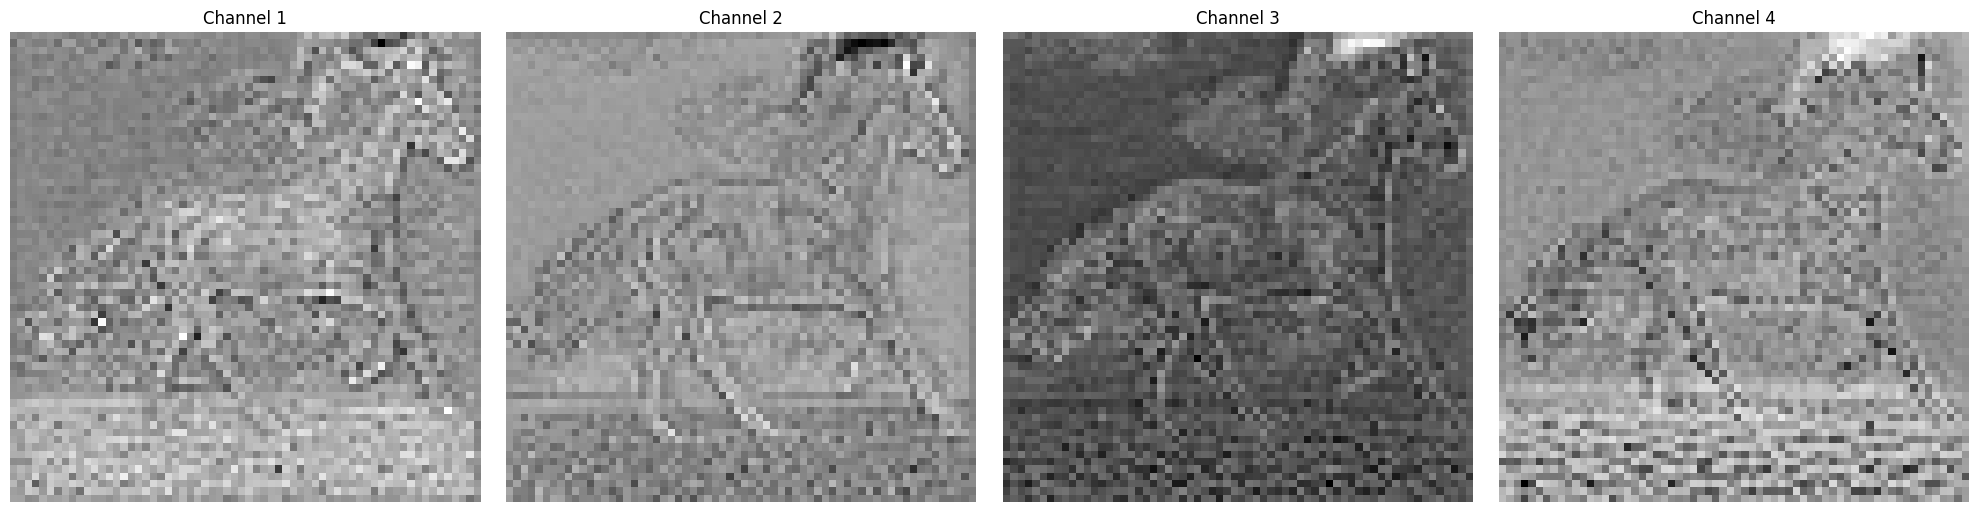

In [ ]:
# visualizing the latents.
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(clipped_difference[0][i].to('cpu').detach().numpy(), cmap='gray')
    axs[i].axis('off')  # Hide axes for better visualization
    axs[i].set_title(f"Channel {i + 1}")

plt.tight_layout()
plt.show()

In [ ]:
normalized_difference = (clipped_difference - clipped_difference.min()) / (clipped_difference.max() - clipped_difference.min())
mask = (normalized_difference > 0.5).float()

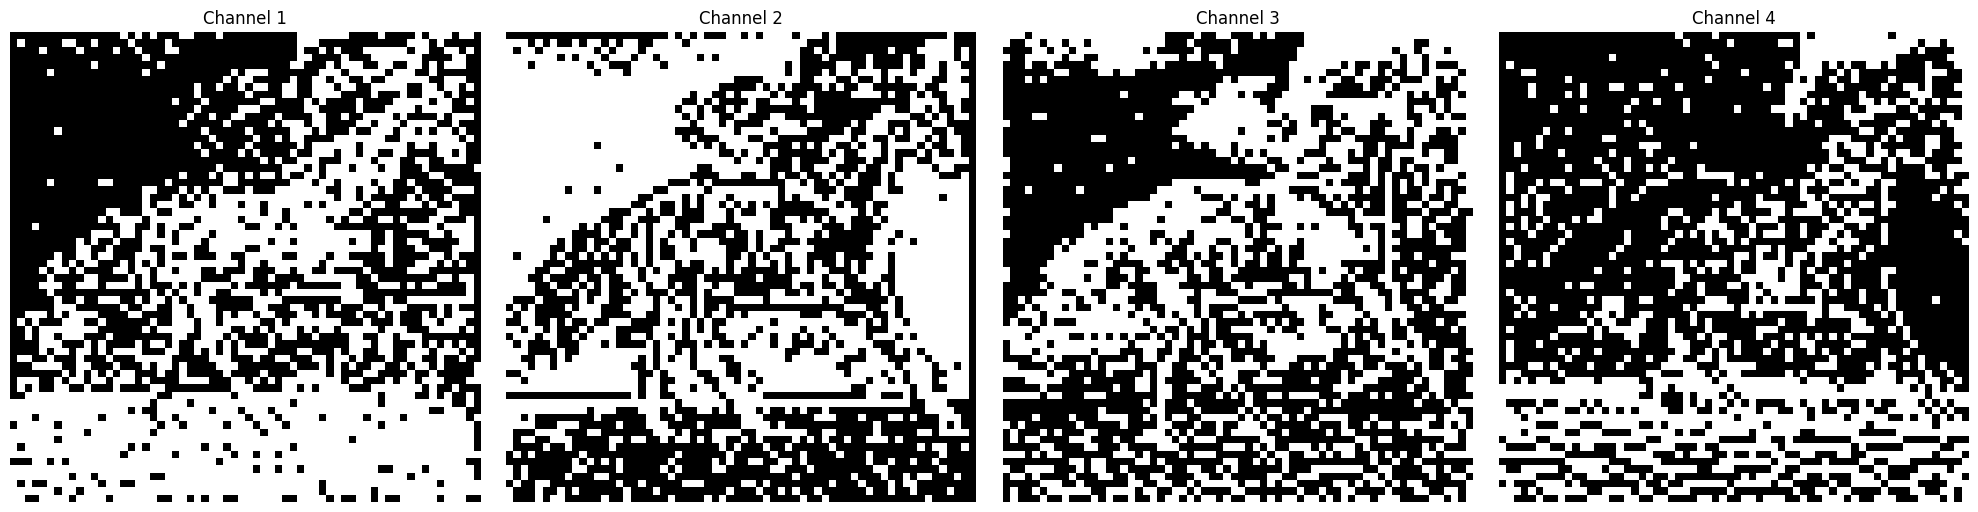

In [ ]:
# visualizing the latents.
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(mask[0][i].to('cpu').detach().numpy(), cmap='gray')
    axs[i].axis('off')  # Hide axes for better visualization
    axs[i].set_title(f"Channel {i + 1}")

plt.tight_layout()
plt.show()

# Exp - 1.2.3 - With Euclidean Distance - Correct way



In [8]:
def img_to_latents(im_tensor):
  im_tensor = im_tensor.to(torch.float16).to(vae.device)*2-1
  with torch.no_grad():
    latents = vae.encode(im_tensor[None, :]).latent_dist.sample()
  return latents

def visualize_latents(latents):
  # visualizing the latents.
  fig, axs = plt.subplots(1, latents.shape[1], figsize=(20, 5))

  for i in range(latents.shape[1]):
      axs[i].imshow(latents[0][i].to('cpu').detach().numpy(), cmap='gray')
      axs[i].axis('off')  # Hide axes for better visualization
      axs[i].set_title(f"Channel {i + 1}")

  plt.tight_layout()
  plt.show()

In [9]:
def encode_text(inputs = ['']):

    uncond_inputs = [''] * len(inputs)
    all_inputs = uncond_inputs + inputs
    all_inputs_tokenized = tokenizer(all_inputs, padding = 'max_length', max_length = tokenizer.model_max_length, truncation=True, return_tensors="pt").input_ids.to('cuda')
    with torch.no_grad():
      embeddings = text_encoder(all_inputs_tokenized)[0].half()

    return embeddings



torch.Size([1, 4, 64, 64])


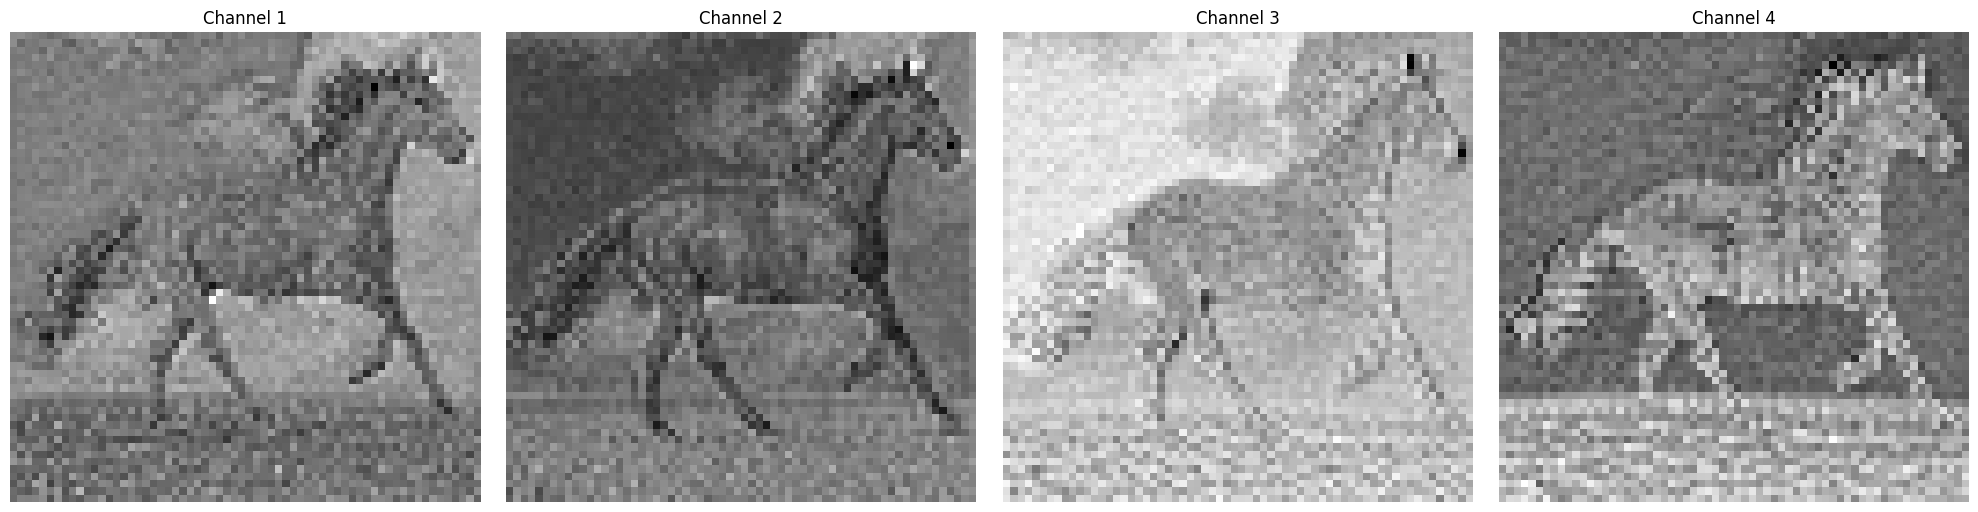

In [10]:
latents = img_to_latents(im_tensor)
print(latents.shape)
visualize_latents(latents)

In [11]:
def get_noise_inhalf(im_latents, prompt, strength = 0.5, seed = 100, guidance_scale = 7.5, num_timesteps = 50):

  torch.manual_seed(seed)
  p_embs = encode_text([prompt])

  #scale the embeddings
  scaled_latents = im_latents.clone() * vae.config.scaling_factor

  # Get the timestep
  scheduler.set_timesteps(num_timesteps)
  start_timestep_index = int(num_timesteps * strength)

  # Generate Noise and add the noise to the scaled latents
  noise = torch.randn_like(scaled_latents, dtype = scaled_latents.dtype, device = scaled_latents.device)
  noisy_latents = scheduler.add_noise(scaled_latents, noise, torch.tensor([scheduler.timesteps[start_timestep_index]], device = scaled_latents.device))

  # Run the diffusion process once on that timestep and get the results

  ts = scheduler.timesteps[start_timestep_index]
  input = torch.cat([noisy_latents]*2, dim = 0)
  input = scheduler.scale_model_input(input, ts)

  with torch.no_grad():
      noise_pred = unet(input, ts, encoder_hidden_states = p_embs).sample

  u, p = noise_pred.chunk(2)
  pred = u + guidance_scale * (p - u)
  noisy_latents = scheduler.step(pred, ts, noisy_latents).prev_sample

  return pred

def get_mask(im_latents, ref, query, n = 10):

    seeds = torch.randint(low = 0, high = 7*10**6, size = (10,))
    noise_diffs = []
    for i, sd in enumerate(tqdm(seeds)):
        ref_noise = get_noise_inhalf(latents, 'Horse', strength = 0.5, seed = sd, guidance_scale = 7.5, num_timesteps = 50)
        query_noise = get_noise_inhalf(latents, 'Zebra', strength = 0.5, seed = sd, guidance_scale = 7.5, num_timesteps = 50)

        ## Calculate Eucledian distance between two noises and then average it on axis 0

        noise_diff = (query_noise - ref_noise)[0].pow(2).sum(dim = 0).pow(0.5)
        noise_diffs.append(noise_diff[None, :])

    noise_diff_t = torch.cat(noise_diffs, dim = 0)
    noise_diff_mean = torch.mean(noise_diff_t, dim = 0)
    # Normalization
    normalized_difference = (noise_diff_mean - noise_diff_mean.min()) / (noise_diff_mean.max() - noise_diff_mean.min())
    # Masking
    mask = (normalized_difference > 0.1).float()
    return mask



In [ ]:
mask = get_mask(latents, 'Horse', 'Zebra')

  0%|          | 0/10 [00:00<?, ?it/s]

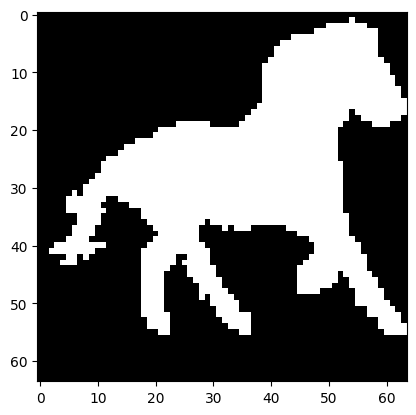

In [ ]:
plt.imshow(mask.cpu().detach().numpy(), cmap = 'gray')

In [ ]:
# Test
noise_ref = get_noise_inhalf(latents, "Horse", strength = 0.5, seed = 100, guidance_scale = 7.5, num_timesteps = 50)
noise_query = get_noise_inhalf(latents, "Zebra", strength = 0.5, seed = 100, guidance_scale = 7.5, num_timesteps = 50)
noise_diff = (noise_query - noise_ref)



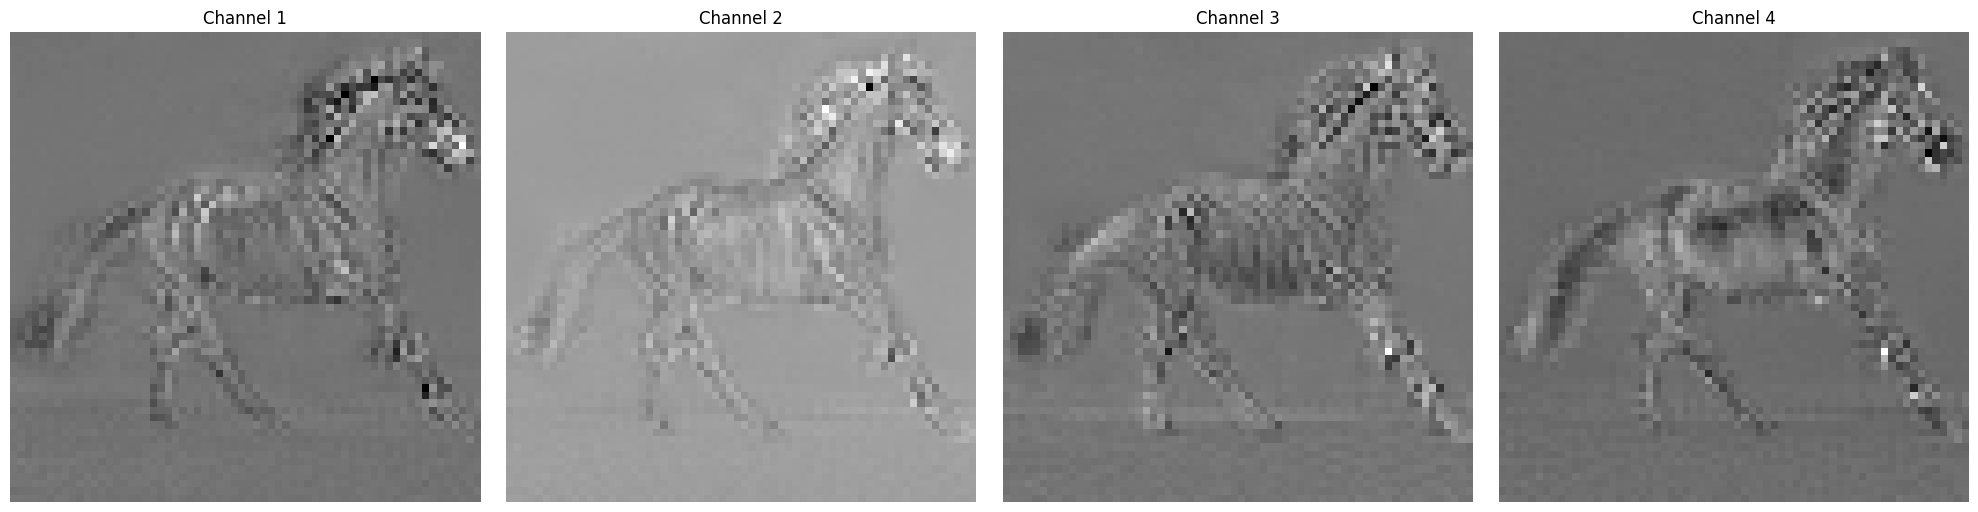

In [ ]:
normalized_noise_diff = (noise_diff - noise_diff.min())/(noise_diff.max() - noise_diff.min())
visualize_latents(normalized_noise_diff)

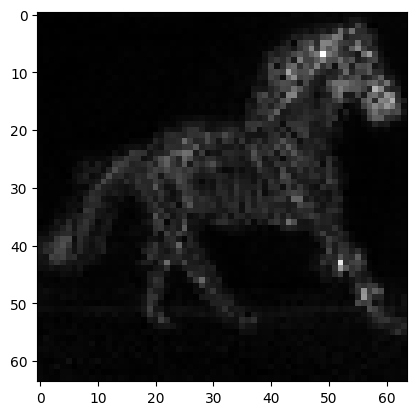

In [ ]:
plt.imshow((noise_query - noise_ref)[0].pow(2).sum(dim = 0).pow(0.5).cpu().detach().numpy(), cmap = 'gray')

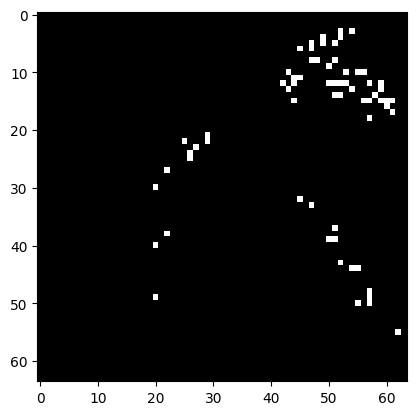

In [ ]:
# Demonstration of normal noise difference vs eucledian distance
noise_diff_sum = noise_diff[0].sum(dim = 0)
normalized_noise_diff = (noise_diff_sum - noise_diff_sum.min())/(noise_diff_sum.max() - noise_diff_sum.min())
mask_v2 = (normalized_noise_diff > 0.6).float()
plt.imshow(mask_v2.cpu().detach().numpy(), cmap = 'gray')

In [ ]:
scheduler.timesteps[25], scheduler.sigmas[25]

(tensor(489.3061), tensor(1.5617))

# Step - 2 and 3 - Adding noise step by step.



In [ ]:
?? scheduler.add_noise

In [ ]:
?? scheduler.scale_model_input

In [ ]:
scheduler.sigmas

tensor([14.6146, 14.5263, 14.4386,  ...,  0.0413,  0.0292,  0.0000])

In [ ]:
scheduler.set_timesteps(50)
scheduler.timesteps[25:]

tensor([489.3061, 468.9184, 448.5306, 428.1429, 407.7551, 387.3673, 366.9796,
        346.5918, 326.2041, 305.8163, 285.4286, 265.0408, 244.6531, 224.2653,
        203.8775, 183.4898, 163.1020, 142.7143, 122.3265, 101.9388,  81.5510,
         61.1633,  40.7755,  20.3878,   0.0000])

In [ ]:
def edit_image(image_latents, mask, query_text, strength = 0.5, num_timesteps = 50):
  mask = mask.to(torch.float16)
  embs = encode_text([query_text])

  scaled_latents = image_latents.clone() * vae.config.scaling_factor

  scheduler.set_timesteps(num_timesteps)
  start_timestep_index = int(num_timesteps * strength)

  # Generate Noise and add the noise to the scaled latents
  noise = torch.randn_like(scaled_latents, dtype = scaled_latents.dtype, device = scaled_latents.device)

  yt = None

  for i, ts in enumerate(tqdm(scheduler.timesteps[start_timestep_index:])):

    xt = scheduler.add_noise(scaled_latents, noise, torch.tensor([ts], device = scaled_latents.device))

    if yt == None:
      yt = xt.clone()

    input = torch.cat([yt]*2, dim = 0)
    input = scheduler.scale_model_input(input, ts)

    with torch.no_grad():
      pred = unet(input, ts, encoder_hidden_states=embs).sample

    n_u, n_t = pred.chunk(2)
    noise = n_u + 7.5 * (n_t - n_u)

    yt_hat = scheduler.step(noise, ts, yt).prev_sample
    yt = mask * yt_hat + (1 - mask) * xt

  return yt



In [ ]:
embs = encode_text(['Zebra'])

scaled_latents = latents.clone() * vae.config.scaling_factor

scheduler.set_timesteps(50)
start_timestep_index = 25

# Generate Noise and add the noise to the scaled latents
noise = torch.randn_like(scaled_latents, dtype = scaled_latents.dtype, device = scaled_latents.device)

yt = None



In [ ]:
mask = mask.to(torch.float16)
for i, ts in enumerate(tqdm(scheduler.timesteps[10:])):

    xt = scheduler.add_noise(scaled_latents, noise, torch.tensor([ts], device = scaled_latents.device))

    if yt == None:
      yt = xt.clone()

    input = torch.cat([yt]*2, dim = 0)
    input = scheduler.scale_model_input(input, ts)

    with torch.no_grad():
      pred = unet(input, ts, encoder_hidden_states=embs).sample

    n_u, n_t = pred.chunk(2)
    noise = n_u + 7.5 * (n_t - n_u)

    yt_hat = scheduler.step(noise, ts, yt).prev_sample
    yt = mask * yt_hat + (1 - mask) * xt

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

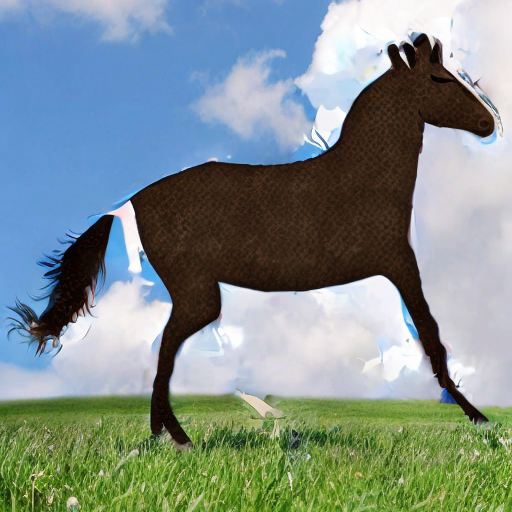

In [ ]:
yt = edit_image(latents, mask, 'A zebra on a grass field with a cloudy sky', strength = 0.1, num_timesteps = 70)

with torch.no_grad():
  image = vae.decode(1 / 0.18215 * yt).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

  0%|          | 0/49 [00:00<?, ?it/s]

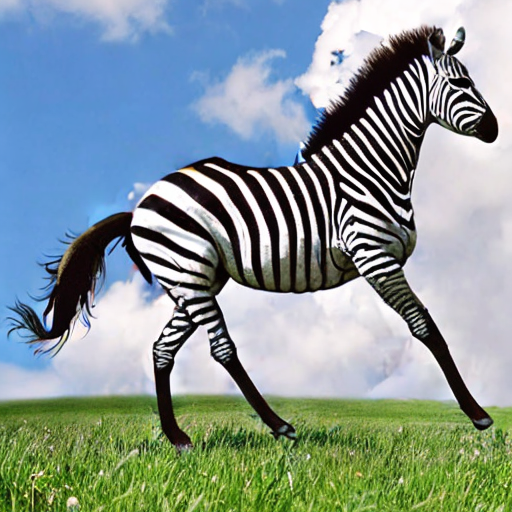

In [ ]:
yt = edit_image(latents, mask, 'A zebra on a grass field with a cloudy sky', strength = 0.3, num_timesteps = 70)

with torch.no_grad():
  image = vae.decode(1 / 0.18215 * yt).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

  0%|          | 0/49 [00:00<?, ?it/s]

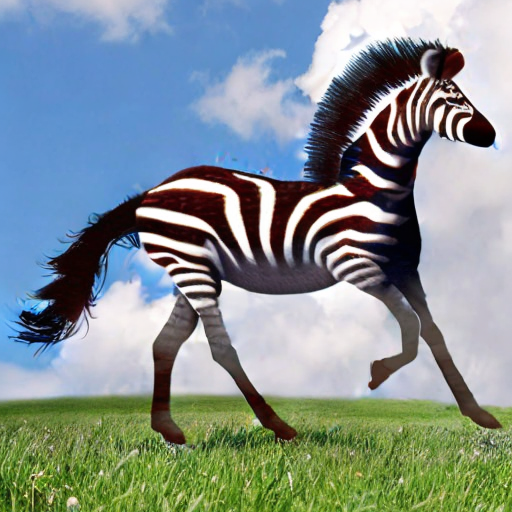

In [ ]:
yt = edit_image(latents, mask, 'A zebra on a grass field with a cloudy sky', strength = 0.3, num_timesteps = 70)

with torch.no_grad():
  image = vae.decode(1 / 0.18215 * yt).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

# Same with noise scaling.

In [75]:
def get_noise_inhalf_scaled(im_latents, prompt, strength = 0.5, seed = 100, guidance_scale = 1.0, num_timesteps = 50):

  torch.manual_seed(seed)
  p_embs = encode_text([prompt])

  #scale the embeddings
  scaled_latents = im_latents.clone() * vae.config.scaling_factor

  # Get the timestep
  scheduler.set_timesteps(num_timesteps)
  start_timestep_index = int(num_timesteps * strength)

  # Generate Noise and add the noise to the scaled latents
  noise = torch.randn_like(scaled_latents, dtype = scaled_latents.dtype, device = scaled_latents.device)
  noisy_latents = scheduler.add_noise(scaled_latents, noise, torch.tensor([scheduler.timesteps[start_timestep_index]], device = scaled_latents.device))

  # Run the diffusion process once on that timestep and get the results

  ts = scheduler.timesteps[start_timestep_index]
  input = torch.cat([noisy_latents]*2, dim = 0)
  input = scheduler.scale_model_input(input, ts)

  with torch.no_grad():
      noise_pred = unet(input, ts, encoder_hidden_states = p_embs).sample

  u, p = noise_pred.chunk(2)
  pred = u + torch.norm(u, p = 2) * 0.4* (p - u)/torch.norm(p - u, p = 2)
  norm_pred = pred * torch.norm(u, p = 2)/torch.norm(pred, p = 2)

  noisy_latents = scheduler.step(norm_pred, ts, noisy_latents).prev_sample

  return norm_pred

def get_mask_scaled(im_latents, ref, query, n = 10, threshold = 0.1):

    seeds = torch.randint(low = 0, high = 7*10**6, size = (10,))
    noise_diffs = []
    for i, sd in enumerate(tqdm(seeds)):
        ref_noise = get_noise_inhalf_scaled(latents, ref, strength = 0.5, seed = sd, guidance_scale = 7.5, num_timesteps = 50)
        query_noise = get_noise_inhalf_scaled(latents, query, strength = 0.5, seed = sd, guidance_scale = 7.5, num_timesteps = 50)

        ## Calculate Eucledian distance between two noises and then average it on axis 0

        noise_diff = (query_noise - ref_noise)[0].pow(2).sum(dim = 0).pow(0.5)
        noise_diffs.append(noise_diff[None, :])

    noise_diff_t = torch.cat(noise_diffs, dim = 0)
    noise_diff_mean = torch.mean(noise_diff_t, dim = 0)
    # Normalization
    normalized_difference = (noise_diff_mean - noise_diff_mean.min()) / (noise_diff_mean.max() - noise_diff_mean.min())
    # Masking
    mask = (normalized_difference > 0.1).float()
    return mask

In [83]:
mask = get_mask_scaled(latents, 'Horse', 'Zebra', threshold = 0.08)

  0%|          | 0/10 [00:00<?, ?it/s]

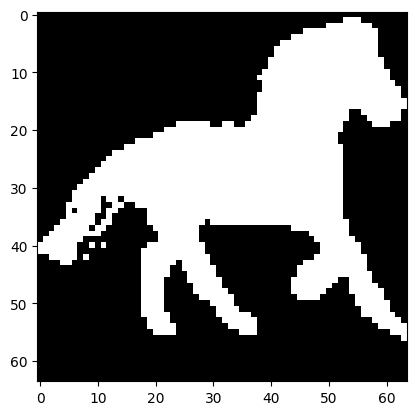

In [84]:
plt.imshow(mask.cpu().detach().numpy(), cmap = 'gray')

In [104]:
def edit_image_scaled(image_latents, mask, query_text, strength = 0.5, num_timesteps = 50):
  mask = mask.to(torch.float16)
  embs = encode_text([query_text])

  scaled_latents = image_latents.clone() * vae.config.scaling_factor

  scheduler.set_timesteps(num_timesteps)
  start_timestep_index = int(num_timesteps * strength)

  # Generate Noise and add the noise to the scaled latents
  noise = torch.randn_like(scaled_latents, dtype = scaled_latents.dtype, device = scaled_latents.device)

  yt = None

  for i, ts in enumerate(tqdm(scheduler.timesteps[start_timestep_index:])):

    xt = scheduler.add_noise(scaled_latents, noise, torch.tensor([ts], device = scaled_latents.device))

    if yt == None:
      yt = xt.clone()

    input = torch.cat([yt]*2, dim = 0)
    input = scheduler.scale_model_input(input, ts)

    with torch.no_grad():
      pred = unet(input, ts, encoder_hidden_states=embs).sample

    u, t = pred.chunk(2)
    noise = u + torch.norm(u, p = 2) * 0.08 * (t - u)/torch.norm(t - u, p = 2)
    norm_noise = noise*torch.norm(u, p = 2)/torch.norm(noise, p = 2)
    yt_hat = scheduler.step(norm_noise, ts, yt).prev_sample
    yt = mask * yt_hat + (1 - mask) * xt

  return yt



  0%|          | 0/53 [00:00<?, ?it/s]

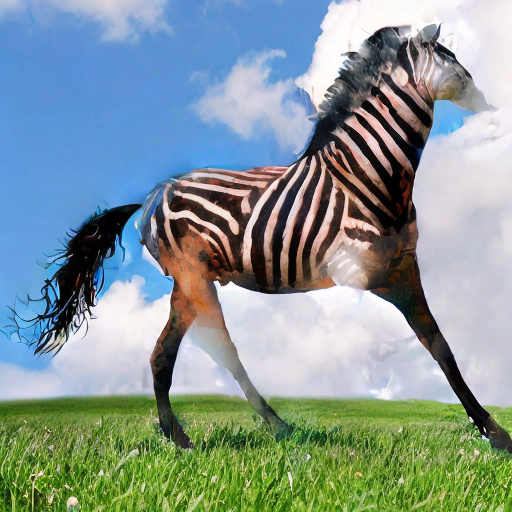

In [105]:
yt = edit_image_scaled(latents, mask, 'A zebra on a grass field with a cloudy sky', strength = 0.25, num_timesteps = 70)

with torch.no_grad():
  image = vae.decode(1 / 0.18215 * yt).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

  0%|          | 0/49 [00:00<?, ?it/s]

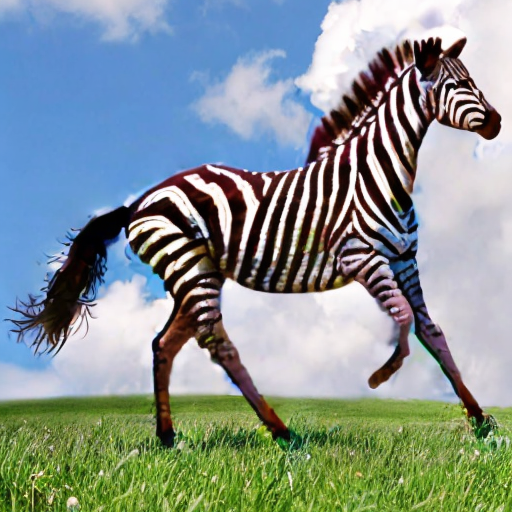

In [98]:
yt = edit_image_scaled(latents, mask, 'A zebra on a grass field with a cloudy sky', strength = 0.3, num_timesteps = 70) # gs = 0.2

with torch.no_grad():
  image = vae.decode(1 / 0.18215 * yt).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

  0%|          | 0/42 [00:00<?, ?it/s]

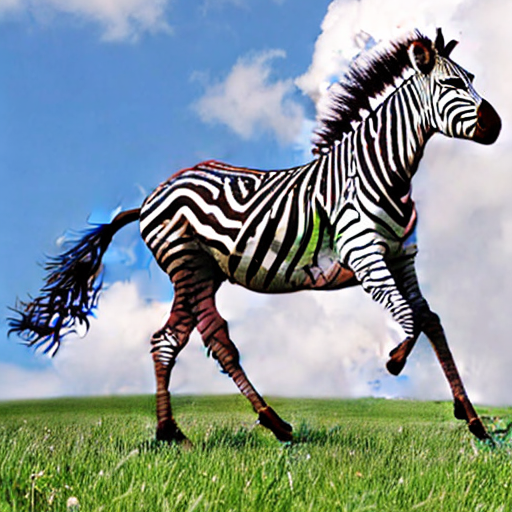

In [74]:
yt = edit_image_scaled(latents, mask, 'A zebra on a grass field with a cloudy sky', strength = 0.4, num_timesteps = 70) # gs = 0.4

with torch.no_grad():
  image = vae.decode(1 / 0.18215 * yt).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)